In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer
from datasets import load_dataset

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation, LayerGradientXActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

from lm import LanguageModel

C:\Users\jzcha\.conda\envs\SalLM\lib\site-packages\pytorch_lightning\metrics\__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fine-tuned model checkpoint paths
ckpt_path_semeval = 'Models/semeval BSST-140/checkpoints/epoch=3-step=1999.ckpt'
ckpt_path_sst5 = 'Models/sst5 BSST-137/checkpoints/epoch=2-step=1601.ckpt'
ckpt_path_stf = 'Models/stf BSST-138/checkpoints/epoch=2-step=1481.ckpt'
# load model
model = LanguageModel.load_from_checkpoint(checkpoint_path=ckpt_path_semeval)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, attention_mask=attention_mask)
    return output

In [4]:
def forward_func(inputs, attention_mask=None):
    logits, attn = model(inputs, attention_mask=attention_mask)
    return logits

In [5]:
sep_token_id = tokenizer.sep_token_id # A token used as a separator between text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the text word sequence

def construct_input_ref_pair(text, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    return torch.tensor([input_ids], device=device)
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)
    
def construct_whole_bert_embeddings(input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    return input_embeddings

# ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
# sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
# cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
#     text_ids = tokenizer.encode(text, add_special_tokens=False)

#     # construct input token ids
#     input_ids = [cls_token_id] + text_ids + [sep_token_id]

#     # construct reference token ids 
#     ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

#     return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

# def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
#     seq_len = input_ids.size(1)
#     token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
#     ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
#     return token_type_ids, ref_token_type_ids

# def construct_input_ref_pos_id_pair(input_ids):
#     seq_length = input_ids.size(1)
#     position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
#     # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
#     ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

#     position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
#     ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
#     return position_ids, ref_position_ids
    
# def construct_attention_mask(input_ids):
#     return torch.ones_like(input_ids)
    
def construct_whole_bert_embeddings(input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    
    return input_embeddings

In [6]:
# build sample dataset
data = load_dataset('hate_speech18')
# let's take an instance from the dataset
subset = data['train'][0]
text = subset['text']
ground_truth = subset['label']

Using custom data configuration default
Reusing dataset hate_speech18 (C:\Users\jzcha\.cache\huggingface\datasets\hate_speech18\default\0.0.0\8033f254483a20d1d10b0f1b56ded1f54326b1617872c537f354a721a6951d47)


In [7]:
input_ids = construct_input_ref_pair(text, sep_token_id, cls_token_id)

attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [8]:
output_fwd = forward_func(input_ids, attention_mask=attention_mask)

In [9]:
lig_ga = LayerGradientXActivation(forward_func, model.classifier.bert.embeddings)
lig_ig = LayerIntegratedGradients(forward_func, model.classifier.bert.embeddings)

attributions_ga = lig_ga.attribute(
    inputs=input_ids, 
    target = torch.tensor(ground_truth).cuda().long(), 
    additional_forward_args=(attention_mask))
attributions_ig = lig_ig.attribute(
    inputs=input_ids, 
    target = torch.tensor(ground_truth).cuda().long(), 
    additional_forward_args=(attention_mask))


In [10]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [11]:
attributions_sum_ga = summarize_attributions(attributions_ga)
attributions_sum_ig = summarize_attributions(attributions_ig)


In [12]:
# Visualizing different word importances per attribution algorithm
vis_ga = viz.VisualizationDataRecord(
                        attributions_sum_ga,
                        torch.max(torch.softmax(output_fwd[0], dim=0)),
                        torch.argmax(output_fwd),
                        torch.argmax(output_fwd),
                        str(ground_truth),
                        attributions_sum_ga.sum(),       
                        all_tokens,
                        convergence_score=None)
vis_ig = viz.VisualizationDataRecord(
                        attributions_sum_ig,
                        torch.max(torch.softmax(output_fwd[0], dim=0)),
                        torch.argmax(output_fwd),
                        torch.argmax(output_fwd),
                        str(ground_truth),
                        attributions_sum_ig.sum(),       
                        all_tokens,
                        convergence_score=None)

print('\033[1m', 'GradientXActivation Visualizations', '\033[0m')
viz.visualize_text([vis_ga]);
print('\033[1m', 'IntegratedGradients Visualizations', '\033[0m')
viz.visualize_text([vis_ig]);

 GradientXActivation Visualizations 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
18,18 (0.85),0,-0.73,"[CLS] as of march 13th , 2014 , the booklet had been downloaded over 18 , 300 times and counting . [SEP]"


 IntegratedGradients Visualizations 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
18,18 (0.85),0,0.23,"[CLS] as of march 13th , 2014 , the booklet had been downloaded over 18 , 300 times and counting . [SEP]"


In [13]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [14]:
layer = 0

In [15]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [16]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

In [17]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'classifier.bert.embeddings.word_embeddings')

C:\Users\jzcha\.conda\envs\SalLM\lib\site-packages\captum\attr\_models\base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [18]:
def forward_func(input_embeddings, attention_mask=None):
    pred = model(input_embeddings, attention_mask=attention_mask, embed=True)
    pred = pred[0]
    return pred

In [19]:
layer_attrs = []
layer_attn_mat = []

input_embeddings = construct_whole_bert_embeddings(input_ids)

for i in range(model.classifier.config.num_hidden_layers):
    lc = LayerGradientXActivation(forward_func, model.classifier.bert.encoder.layer[i])
    layer_attributions = lc.attribute(
        inputs = input_embeddings,
        target = torch.tensor(ground_truth).cuda().long(),
        additional_forward_args=(attention_mask))
    layer_attrs.append(summarize_attributions(layer_attributions[0]))
    layer_attn_mat.append(layer_attributions[1])

In [20]:
# layer x seq_len
layer_attrs = torch.stack(layer_attrs)

# layer x batch x head x seq_len x seq_len
layer_attn_mat = torch.stack(layer_attn_mat)

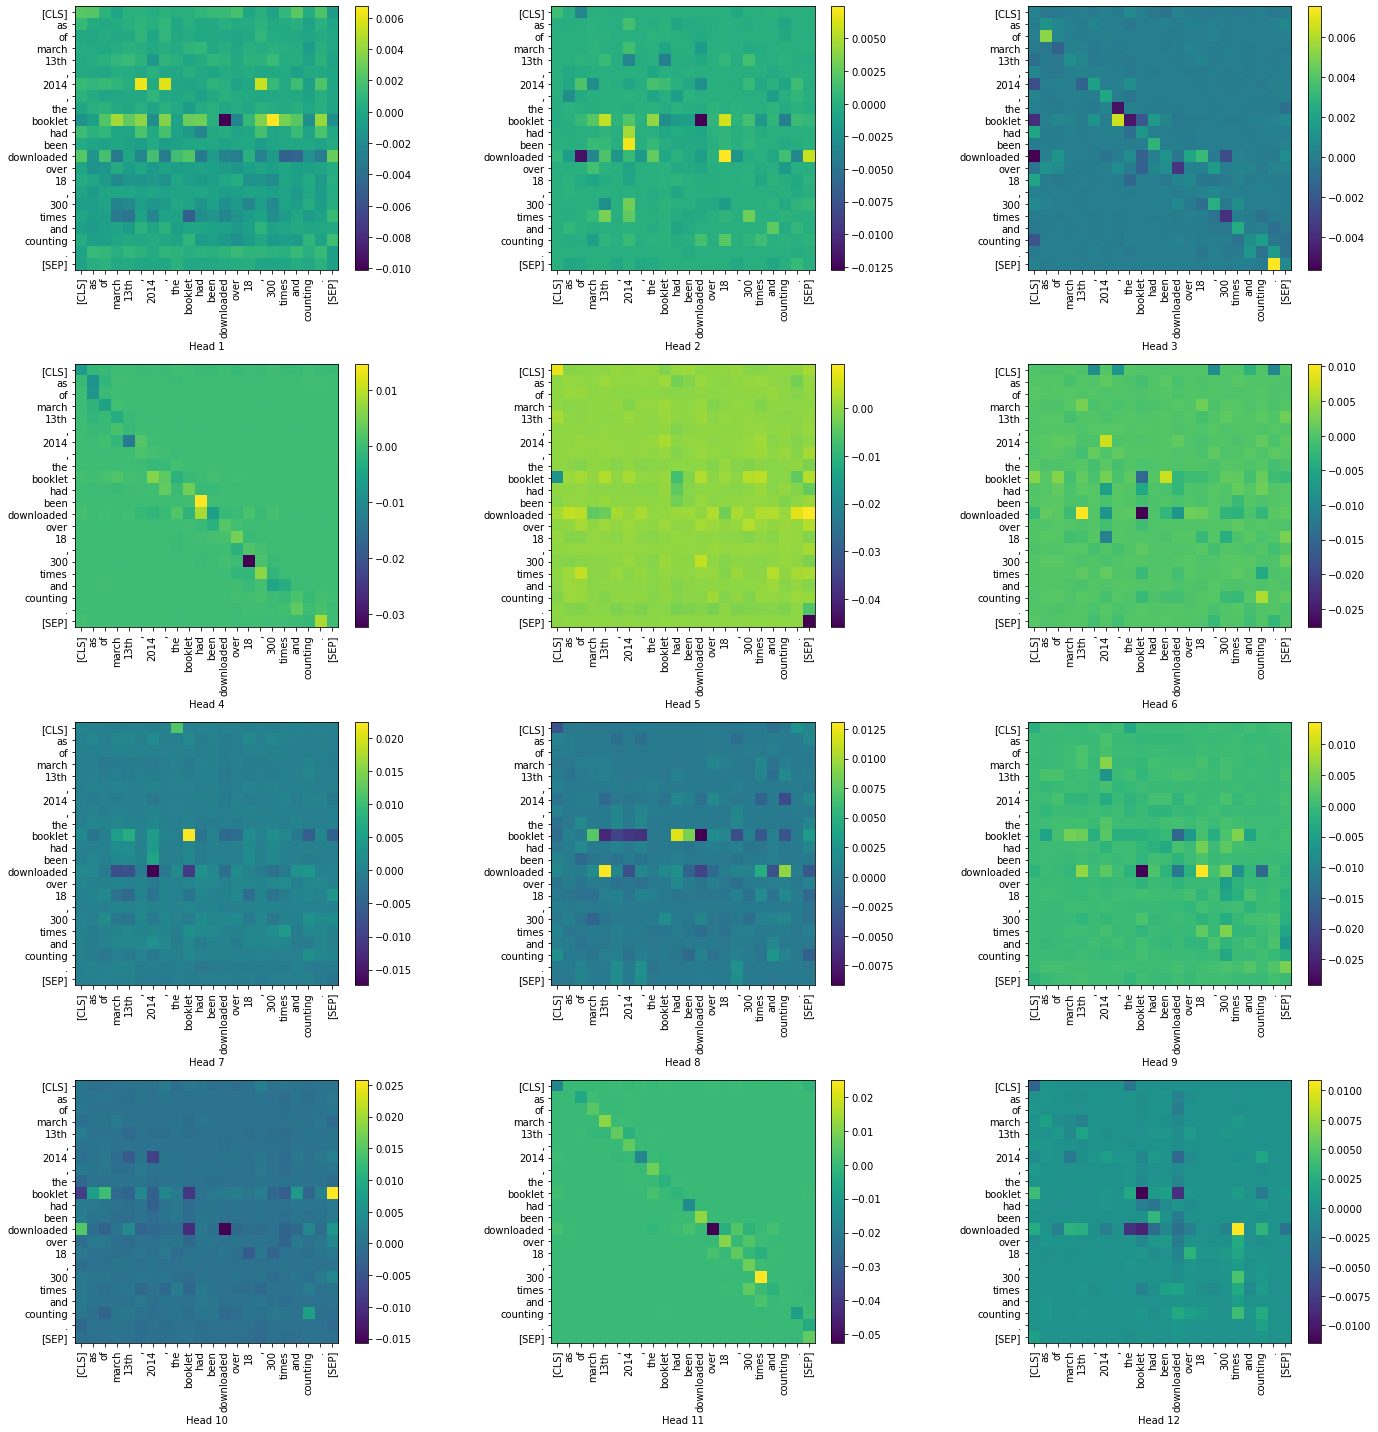

In [21]:
visualize_token2token_scores(layer_attn_mat[layer].squeeze().cpu().detach().numpy())

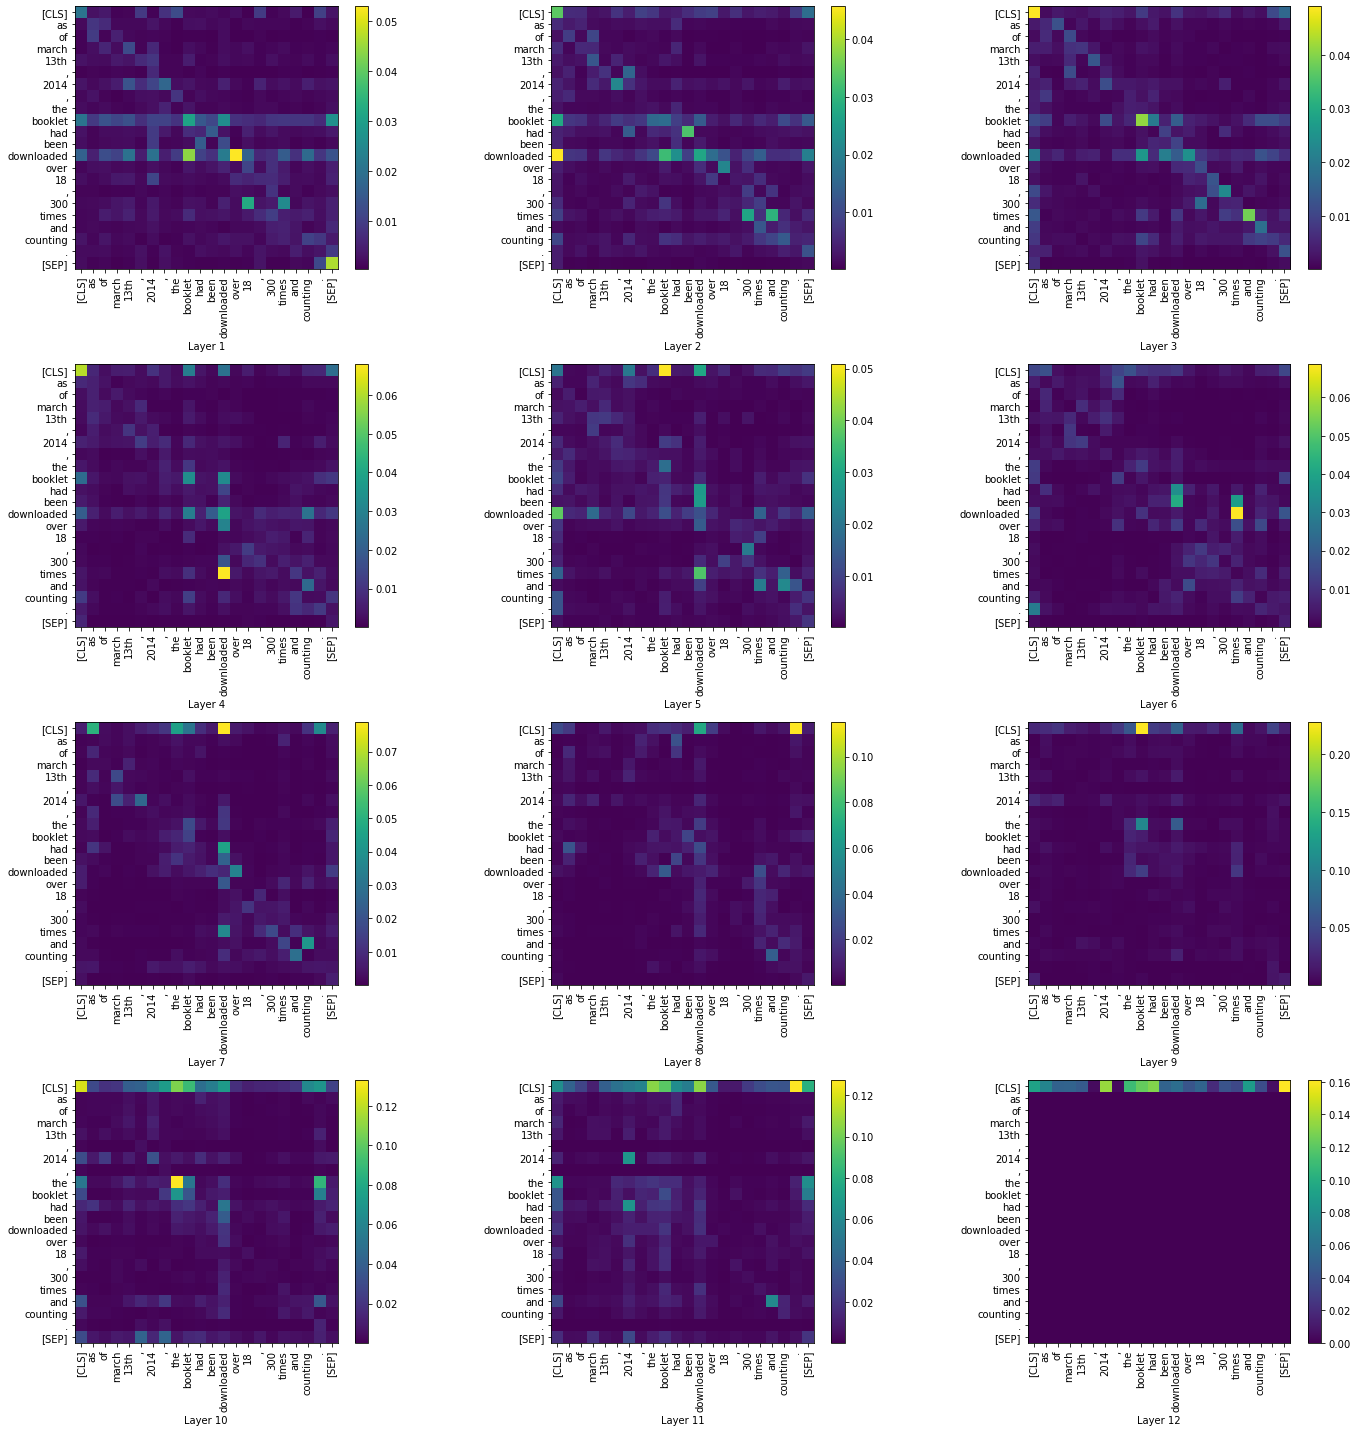

In [22]:
visualize_token2token_scores(norm_fn(layer_attn_mat, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')